# sivtempfit tutorial 

**Author**: [Ruffin Evans](mailto:ruffinevans@gmail.com)

This notebook is a brief introduction to doing Bayesian inference on fluorescence spectra of SiV centers in diamond. So far, the package supports a single model of a broad lorentzian for the SiV and a narrow Lorentzian for the calibration laser.

The package is designed to read in fluorescence spectra in the format returned by our instrument (or work with a generic `pandas` dataframe object) and then use the `emcee` package to sample the posterior distribution of model parameters given the data.

## Getting started
First, import the package. This assumes that the package is already downloaded and installed.

If you need to download and install the package, please see the readme on the [github page](https://github.com/p201-sp2016/sivtempfit).

In [1]:
import sivtempfit as stf
import sivtempfit.io as io
import sivtempfit.inferMC as mc
import sivtempfit.model as model

We will also import a few other fairly standard packages to assist us. All of these packages are requirements for `sivtempfit`, so you should have them installed if the installation of the `sivtempfit` package went well.

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import emcee
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")

## Importing data and the `Spectrum` object

In general, you will have some experimental data that consists of one-dimensional fluorescence spectra, i.e. fluorescence intensity or counts as a function of wavelength.

The package includes support for data in a simple `[x, y]` format where `x` is a numpy array of the x values and `y` is a numpy array of the y values.

The package also includes support for a `Spectrum` object, which is basically just a pandas dataframe with a `metadata` variable bolted onto it. The `sivtempfit.io` module includes some utilities to import these `Spectrum` objects, and the `Spectrum` object itself supports json output through the `write_json` method.

Finally, the package supports reading in the strange `csv` files created by our data acquisition software, including for multi-acquisition experiments.

We'll use such a `Spectrum` object in this tutorial. These objects can be instantiated as `Spectrum(DataFrame, metadata)` where `DataFrame` is the spectrum data as a `pandas` `DataFrame` and `metadata` is a dict of anything else that you want to use to describe the spectrum.

For the purposes of this tutorial, let's import some example data (included with the package.) Let's import a `Spectrum` using the `io` module. `Spectrum` objects are natively stored as `json`.

In [3]:
path_to_json = io.get_example_data_file_path("test_experimental_spectrum.json")
loaded_spectrum = io.load_Spectrum(path_to_json)

Now, `test_spectrum` is a `Spectrum` object that has both data and metadata. We can examine both:

In [4]:
loaded_spectrum.data[:10]

,counts,wavelength
0,1157,730.7841
1,1161,730.7931
10,1170,730.8741
100,1168,731.6841
1000,1543,739.7841
1001,1540,739.7931
1002,1562,739.8021
1003,1550,739.8111
1004,1539,739.8201
1005,1589,739.8291


In [5]:
loaded_spectrum.metadata

{'Laser Frequency': '401.496 THz',
 'Name': 'Example spectrum of an SiV plus a laser calibration line taken at 300K.'}

We can also import the files created by the Horiba multi-acquisition DAQ software, in which case a list of `Spectrum` objects is returned. The header with the list of separate temperatures is automatically stripped away and stored in the metadata of each `Spectrum` object.

In [6]:
path_to_data = io.get_example_data_file_path("varying acquisition time horiba.txt")
spectra_multi = io.import_horiba_multi(path_to_data)

As promised, we can see that the metadata are indeed different for each spectrum.

In [7]:
spectra_multi[0].metadata

{'File creation time': 1462375505.860759,
 'Original file path': 'Spectrum with laser line at 401.496 from 330K to 310K_1s integration.txt',
 'Temperature': 331.18}

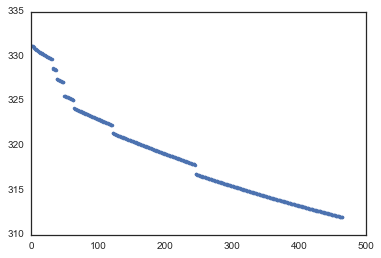

In [8]:
plt.plot([x.metadata['Temperature'] for x in spectra_multi], ".")

It is also possible to include additional metadata during import. A list of dicts can also be added if each spectrum should have different attributes.

In [9]:
spectra_multi = io.import_horiba_multi(path_to_data, metadata={'Purpose': 'Demonstrate io for tutorial'})

The metadata is appended to each spectrum. Metadata can be manually added to a spectrum using the `add_to_metadata` method of the `Spectrum` object.

In [10]:
spectra_multi[0].metadata

{'File creation time': 1462375505.860759,
 'Original file path': 'Spectrum with laser line at 401.496 from 330K to 310K_1s integration.txt',
 'Purpose': 'Demonstrate io for tutorial',
 'Temperature': 331.18}

## Visualize the example data

Let's visualize the example data. Here, let's work with the first element of that temperature data.

In [11]:
test_spectrum = spectra_multi[0]

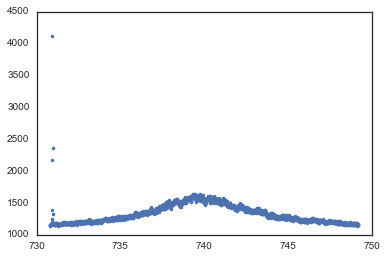

In [12]:
plt.plot(test_spectrum.data['xdata'], test_spectrum.data['ydata1'], ".")

## Set up the model and MC sampling to perform inference

We have a model for this function that includes two lorentzian peaks plus gaussian background noise. The model is described in the likelihood function: 

In [13]:
print(model.two_peak_log_likelihood.__doc__)


    Returns the log-likelihood calculated for the two-peak + CCD noise model.
    See also: two_peak_model
    Parameters:
    -----------
    x : wavelength or x-axis value
    y : corresponding observed data value
    amp1 : amplitude of the broad SiV peak in the spectrum
    amp2 : amplitude of the narrow calibration peak in the spectrum
    T : The temperature of the sample
    m : The linear scaling of the SiV peak position with temperature
    C0 : The offset in the above linear scaling
    center2 : The position of the calibration line
    width1 : The width (FWHM) of the SiV line
    width2 : The width (FWHM) of the calibration line
    light_background : The contribution to the background from stray light,
                       contributing shot noise
    ccd_backgrond : The contribution to the background from CCD readout,
                    contributing gaussian noise
    ccd_stdev : The standard deviation on the gaussian CCD noise

    Optional Arguments:
    ------------

We would like to determine the parameters of the model that fit the data. To do this, we will do Bayesian parameter estimation by sampling the likelihood function using the [`emcee` Monte-Carlo sampler](http://dan.iel.fm/emcee/current/).

The first step is to generate a set of starting points for the sampling; here, we will use an `emcee` `sample_ball` object. **This is normally done automatically in the course of evaluating `mc_likelihood_sampler`** but can also be done manually (and then passed to the `mc_likelihood_sampler`) for more fine-grained control. Even though it's normally not necessary, I will demonstrate the usage here.

Here is an example of the guesses. (Normally, `debug` should be set to `False` to generate the object; when it is `True`, it outputs the values instead.)

For more information, see the `generate_sample_ball` documentation.

In [14]:
print(mc.generate_sample_ball(test_spectrum, 731, debug = True))

((4497.1199999999999, 49.866899999999994, 9, 731, 7.2, 0.0113, 3.5129999999999999, 1112.45, 10), (89.942400000000006, 0.99733799999999995, 0.015, 0.00015, 0.2, 0.0005, 70.259999999999991, 55.622500000000002, 4.0))


We can also visualize the model prediction based on the parameters at the center of the sample ball:

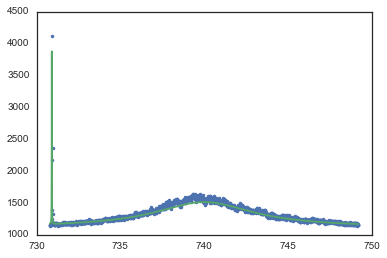

In [15]:
plt.plot(test_spectrum.data['xdata'], test_spectrum.data['ydata1'], ".")
plt.plot(test_spectrum.data['xdata'], mc.generate_sample_ball(test_spectrum, 730.9, return_y_values=True), "-")

As you can see, the default guess is pretty decent. Because the calibration peak is very sharp, the likelihood for the center position should also be very sharply peaked. So, let's do as well as we can to guess the position of this calibration peak:

In [16]:
calib_pos_guess = test_spectrum.data['xdata'][np.argmax(test_spectrum.data['ydata1'])]
calib_pos_guess

730.93709999999999

## Setting up and running the `emcee` sampler

Now, we can run the emcee sampler by calling the `mc_likelihood_sampler` function. which takes as mandatory arguments the data (in either `[x_array, y_array]` form or in the form of a `Spectrum` object) and the expected position of the calibration peak. By default, it runs the sampler right away. This can be disabled with the `run = False` kwarg. 

There are lots of possible arguments to pass to this function, but perhaps the most important is the `gaussian_approx` keyword. By default, the sampler calculates the posterior using a mixed Poisson-Gaussian likelihood (see the `model_development` notebook for more information). This is more accurate for small numbers of photons, but almost three orders of magnitude slower than simply approximating the Poisson noise as Gaussian. Under most circumstances, setting `gaussian_approx=True` is OK. For the sake of time, let's do it here.

Define and run the sampler. If the default parameter guess is bad, you can pass in a better one using the `starting_pos` argument as described in the docstring.

This should take no more than a minute or two.

In [17]:
%time test_sampler = mc.mc_likelihood_sampler(test_spectrum, calib_pos_guess, nwalkers=64, nsteps=2500, threads=4, gaussian_approx=True)

Wall time: 43.7 s


## Extract results from the `emcee` sampler

Let's look at the traces to estimate the burn-in time. You should always do this when you start working on a new dataset to make sure the sampler is doing the right thing. This plotting command actually takes quite a bit of time (also a minute or two), so please be patient.

[ 0.35    0.3144  0.348   0.2312  0.2964  0.3172  0.3024  0.3184  0.3392
  0.3388  0.3312  0.35    0.2216  0.3328  0.3316  0.3132  0.342   0.2992
  0.3184  0.318   0.3292  0.3224  0.2852  0.3272  0.3356  0.342   0.32
  0.2928  0.3192  0.3316  0.3124  0.3256  0.3284  0.3296  0.2708  0.336
  0.2756  0.3484  0.3112  0.338   0.3056  0.3224  0.3072  0.2772  0.3156
  0.3132  0.3004  0.2988  0.3212  0.3272  0.3388  0.3508  0.3232  0.32
  0.3344  0.3256  0.3012  0.3044  0.338   0.3     0.3148  0.3152  0.2832
  0.3032]
[ 82.94073605  89.16129193  72.37340217  86.54496521  90.44113759
  79.19477542  65.60253969  66.55268629  95.68230514]


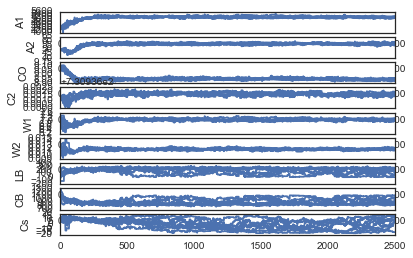

In [18]:
fig, (ax_amp1, ax_amp2, ax_c0, ax_center2, ax_width1, ax_width2, ax_lb, ax_ccdb, ax_ccds) = plt.subplots(9)
ax_amp1.set(ylabel='A1')
ax_amp2.set(ylabel='A2')
ax_c0.set(ylabel='CO')
ax_center2.set(ylabel='C2')
ax_width1.set(ylabel='W1')
ax_width2.set(ylabel='W2')
ax_lb.set(ylabel='LB')
ax_ccdb.set(ylabel='CB')
ax_ccds.set(ylabel='Cs')
for i in range(9):
    sns.tsplot(test_sampler.chain[i,:,0], ax=ax_amp1)
    sns.tsplot(test_sampler.chain[i,:,1], ax=ax_amp2)
    sns.tsplot(test_sampler.chain[i,:,2], ax=ax_c0)
    sns.tsplot(test_sampler.chain[i,:,3], ax=ax_center2)
    sns.tsplot(test_sampler.chain[i,:,4], ax=ax_width1)
    sns.tsplot(test_sampler.chain[i,:,5], ax=ax_width2)
    sns.tsplot(test_sampler.chain[i,:,6], ax=ax_lb)
    sns.tsplot(test_sampler.chain[i,:,7], ax=ax_ccdb)
    sns.tsplot(test_sampler.chain[i,:,8], ax=ax_ccds)
print(test_sampler.acceptance_fraction)
print(test_sampler.acor)

Burn-in definitely seems to have occured by 1500 samples or so, probably earlier.

There are a few built-in utilities to help analyze this data. `parameter_samples_df` flattens the sampler chain and turns it into a pandas dataframe to aid plotting and analysis, and `credible_intervals_from_sampler` returns a set of credible intervals directly from the sampler. The docstrings for these functions describe their use.

For example, we can use such a dataframe to create a pairplot for the parameters:

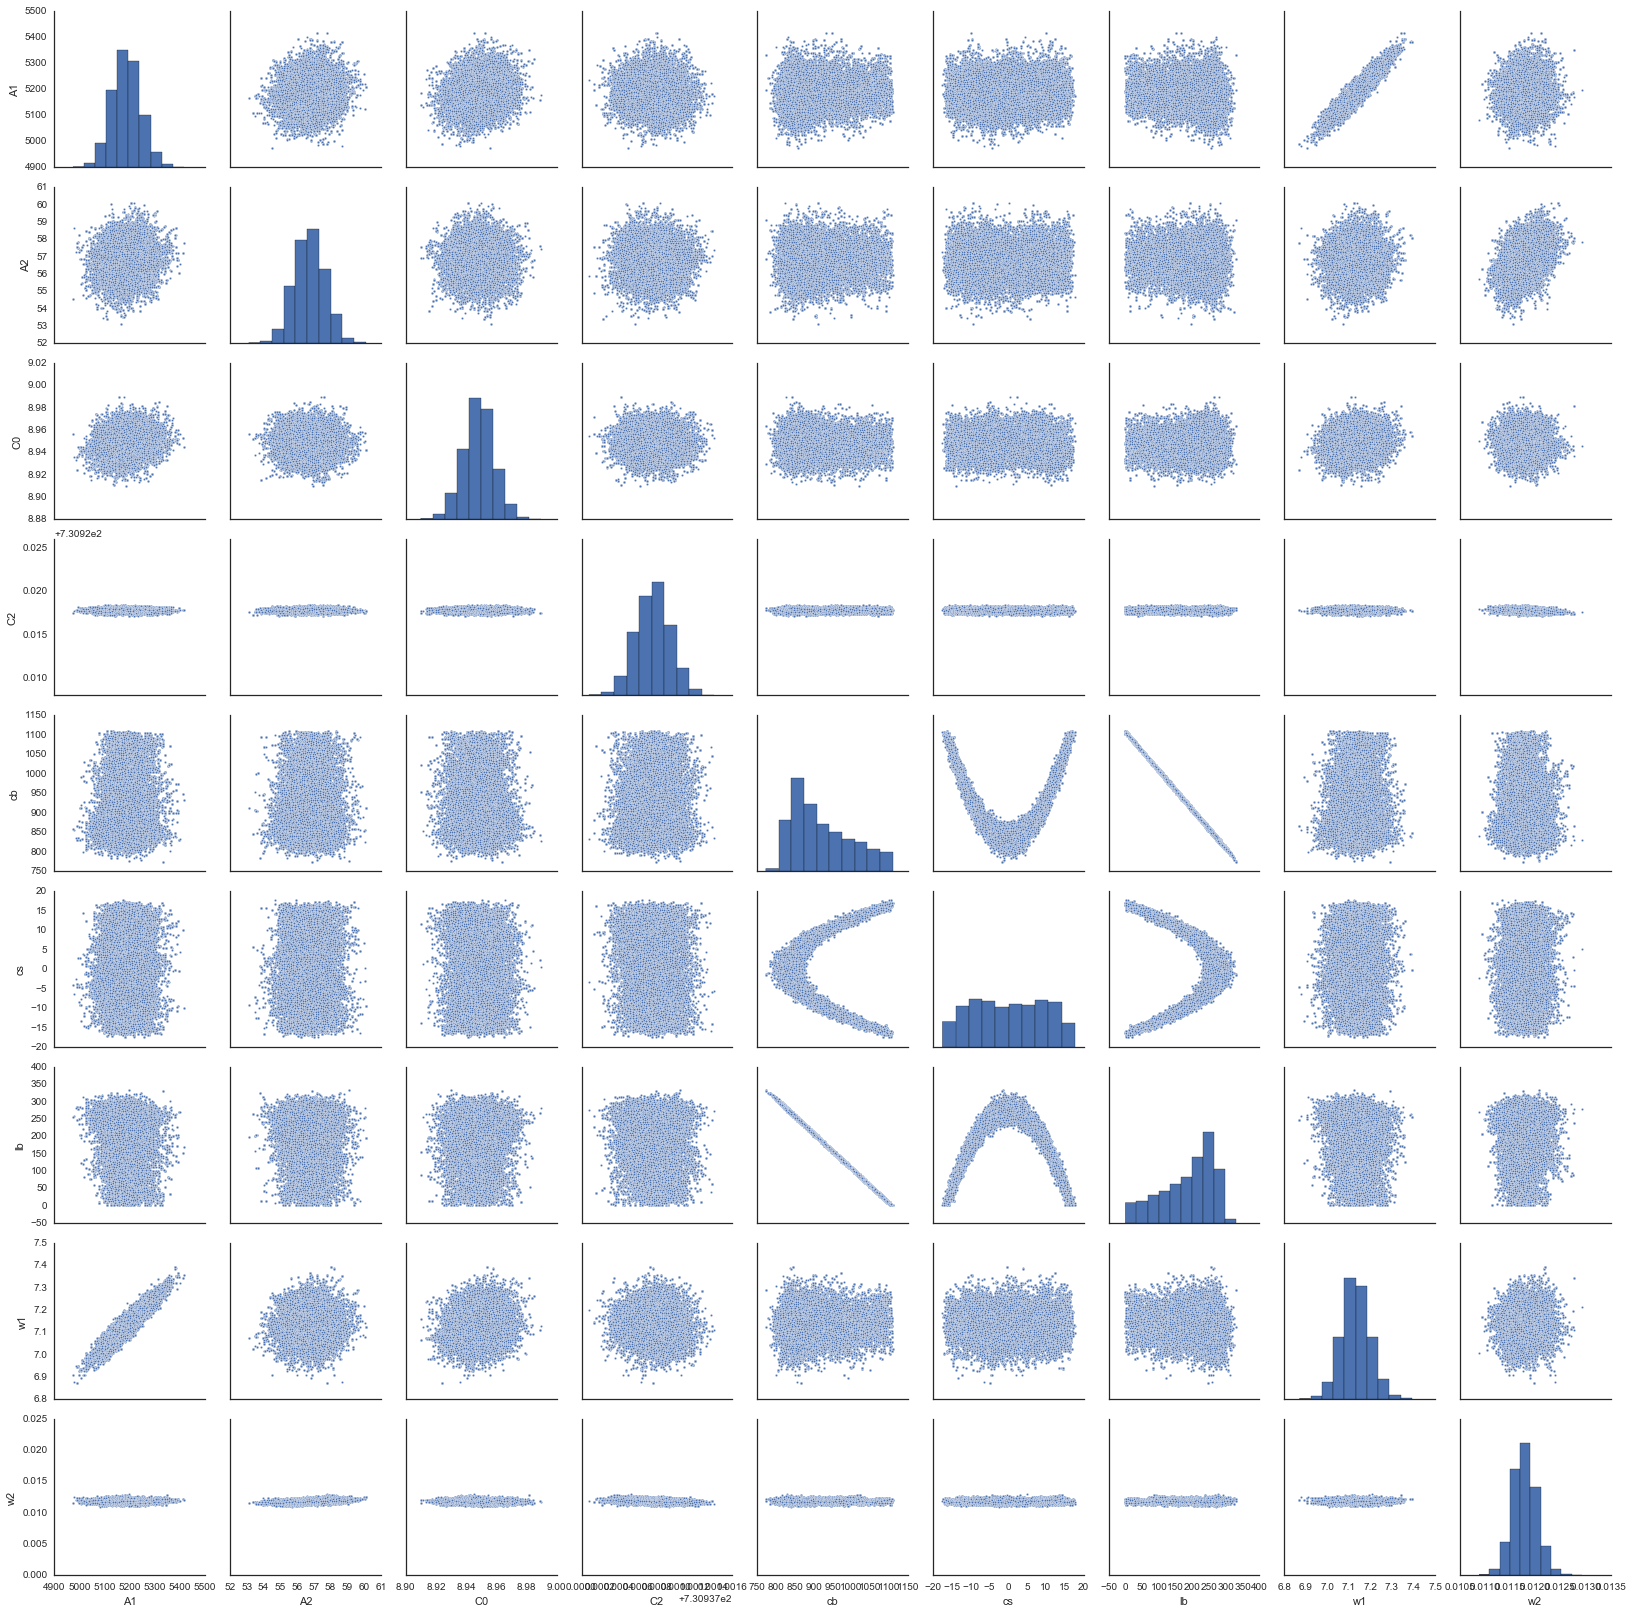

In [19]:
parameter_samples = mc.parameter_samples_df(test_sampler, burn_in = 1500)
sns.pairplot(parameter_samples, markers='.')

There's not much here worth commenting on except for the strangly shaped curves for the joint distribution between `cs` (the standard deviation of the CCD background noise) and `cb` (the extent of that background noise).

Because the noise is parameterized as Poisson + Gaussian noise, and because we are working in the gaussian approximation for the poisson noise, there is no difference between "blaming" some of the noise on the gaussian noise compared to the poisson noise. This can also be seen in the strong anticorrelation between the extent of the gaussian noise and the extent of the poisson noise. However, because physically the noise *is* shot noise, if the Gaussian part of the noise increases to account for the shot noise, the standard deviation must also increase as the square root of the extent of the noise. Because here the standard deviation is allowed to be positive or negative, there is (as we would hope) reflection symmetry around the $\sigma = 0$ plane.

The result that we care about the most is the predicted offset in the center position. This corresponds to the physical wavelength of the SiV center after accounting for the calibration laser position. So, let's plot the marginalized distribution for this parameter:

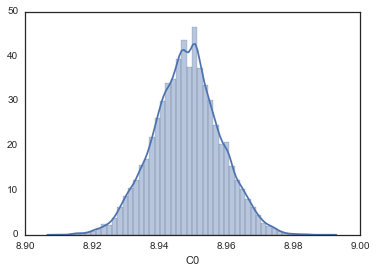

In [20]:
sns.distplot(parameter_samples['C0'])

This looks pretty good -- fairly symmetric, and is centered more or less where we would expect.

To be more quantitative, we can extract MAP 68% credible intervals for each parameter using the following command. Again, see the docstring for how this function can be used.

In [21]:
mc.credible_intervals_from_sampler(test_sampler, burn_in=1500, interval_range=[0.68, 0.95]);


For credibility level 0.680:
A1 = 5185.2206 + 56.8683 - 53.8307
A2 = 56.7355 + 0.8864 - 0.9376
C0 = 8.9482 + 0.0099 - 0.0099
C2 = 730.9378 + 0.0002 - 0.0002
cb = 899.3458 + 113.8785 - 55.5305
cs = 0.1291 + 10.8236 - 10.7623
lb = 207.5019 + 55.3686 - 113.6447
w1 = 7.1305 + 0.0671 - 0.0613
w2 = 0.0118 + 0.0002 - 0.0002

For credibility level 0.950:
A1 = 5185.2206 + 113.4867 - 106.3940
A2 = 56.7355 + 1.7586 - 1.6973
C0 = 8.9482 + 0.0197 - 0.0198
C2 = 730.9378 + 0.0004 - 0.0003
cb = 899.3458 + 189.8872 - 81.3014
cs = 0.1291 + 15.2165 - 15.5215
lb = 207.5019 + 81.2512 - 190.8185
w1 = 7.1305 + 0.1310 - 0.1241
w2 = 0.0118 + 0.0005 - 0.0004


If we'd like to store these results, we can add them back to the Spectrum object as metadata and then use all of the io functions to store and recall spectrum objects.

In [22]:
intervals = mc.credible_intervals_from_sampler(test_sampler, burn_in=1500, interval_range=0.68, print_out=False)
test_spectrum.add_to_metadata({"68% credible intervals" : intervals})

Make sure it worked:

In [23]:
test_spectrum.metadata

{'68% credible intervals': [[5185.2205557133202,
   56.868279442987841,
   53.830683833519288],
  [56.73552683232078, 0.88635063760880684, 0.9376097043171896],
  [8.9481871597508889, 0.0099150960015617073, 0.0098551856164803553],
  [730.93775953175509, 0.00017704166612020344, 0.0001853683706940501],
  [899.34584196730191, 113.87846543519299, 55.53052280686768],
  [0.12907699718517396, 10.82361719939064, 10.762264581747001],
  [207.50185881860625, 55.368627296280465, 113.64469669274402],
  [7.1305373969567984, 0.06707403154226288, 0.061271460671745714],
  [0.011779282006062495, 0.00023993658169597747, 0.00022072201807998328]],
 'File creation time': 1462375505.860759,
 'Original file path': 'Spectrum with laser line at 401.496 from 330K to 310K_1s integration.txt',
 'Purpose': 'Demonstrate io for tutorial',
 'Temperature': 331.18}

### FAQ

*Q: Sampling is taking incredibly long! Help!*

A: You have probably failed to specify the `gaussian_approx=True` keyword argument to the sampler. Remember that calculating the full Poisson-Gaussian likelihood is approximately 500 times slower than the Gaussian approximation. 

*Q: The inference doesn't seem to be working: my chains seem to be straight lines and the pairplots look highly non-Gaussian. What's going on?*

A: Your initial guesses are probably starting you off in a region of low or zero probability. Try playing around with the starting position for the walkers -- familiarize yourself with the arguments for `generate_sample_ball`. Using the above strategy to visualize the center of the sample ball is a valuable one (which is why I included it here.) If that doesn't work, or your starting position already seems quite good, you can also try increasing the number of walkers to increase your coverage in parameter space. I typically run with 100-200 walkers. If you do increase the number of walkers, you may be able to relax the tightness of your sample ball a bit with the `tightness` argument to `generate_sample_ball`.

In any case, you should debug this problem with extremely short sampling chains (10-100 steps) and then look at the acceptance fraction. If it's nonzero for more than half of the chains, you're probably OK to proceed.

### Note on relation to the final project for PHYS 201

These functions and tools are exactly the ones that I used to perform the inference on the final project. I basically just did sampling for different sets of data with different temperatures and different acquisition times and then looked at the estimates and credible intervals for each. If you want to make sure there's no funny business, you can play with doing inference on the different spectra in the `spectra_multi` list. Inference on the other example spectrum may require tweaking the initial sample ball slightly.

The linear fit described near the end of the paper was performed with the matrix-algebraic methods we've been using in the class.